In [242]:
%matplotlib inline
from scrape_scholar import scrape
from flask import Flask
import sqlite3
import pandas as pd
import itertools
import networkx as nx

In [ ]:
# Testando
papers = scrape('Evandro Parente')

# Criando a base de dados

In [192]:
schema = """
DROP TABLE IF EXISTS "author";
DROP TABLE IF EXISTS "paper";
DROP TABLE IF EXISTS "author_paper";
CREATE TABLE "author" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "author_name" VARCHAR NOT NULL UNIQUE
);
CREATE TABLE "paper" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "paper_name" VARCHAR NOT NULL UNIQUE
);
CREATE TABLE "author_paper" (
    paper_id VARCHAR,
    author_id VARCHAR,
    FOREIGN KEY(paper_id) REFERENCES paper(paper_name)
    FOREIGN KEY(author_id) REFERENCES author(author_name)
);
"""

In [193]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
cursor = conn.cursor()
cursor.executescript(schema)
conn.commit()
conn.close()

In [194]:
ins_paper_author ="""
INSERT INTO author_paper (paper_id, author_id) \
    VALUES (?,?);
"""

conn = sqlite3.connect('hw1.sqlite',timeout=10)
for i in papers:
    pairs = list(itertools.product([i['title']],i['authors']))
    for pair in pairs:
        conn.execute(ins_paper_author,pair)
conn.commit()
conn.close()

In [195]:
autores =sorted(set([i for sublist in [i['authors'] for i in papers] for i in sublist]))
articles= [i['title'] for i in papers]

In [196]:
ins_author = """
INSERT OR IGNORE INTO author (author_name) VALUES (?);
"""
conn = sqlite3.connect('hw1.sqlite',timeout=10)
for autor in autores:
    conn.execute(ins_author,[autor])
conn.commit()
conn.close()

In [197]:
ins_paper = """
INSERT OR IGNORE INTO paper (paper_name) VALUES (?);
"""
conn = sqlite3.connect('hw1.sqlite',timeout=10)
for paper in articles:
    conn.execute(ins_paper,[paper])
conn.commit()
conn.close()

In [199]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
conn.close()
# for row in conn.execute('SELECT * FROM paper'):
#     print(row)

In [213]:
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""

In [230]:
conn = sqlite3.connect('hw1.sqlite')
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()
edges_authors= pd.DataFrame(edges_authors,columns=['paper','author1','author2'])

In [235]:
edges_authors.head()

,paper,author1,author2
0,An object-oriented framework for finite elemen...,E Parente Jr,LF Martha
1,Improvement of semi‐analytical design sensitiv...,E Parente Jr,LE Vaz
2,A hybrid shared/distributed memory parallel ge...,E Parente Jr,I Rocha
3,A hybrid shared/distributed memory parallel ge...,AMC Melo,E Parente Jr
4,A hybrid shared/distributed memory parallel ge...,AMC Melo,I Rocha


In [219]:
query_pair_papers = """
SELECT author_id,
       a1.paper_id AS paper1,
       a2.paper_id AS paper2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (author_id)
WHERE a1.paper_id < a2.paper_id;
"""

In [232]:
conn = sqlite3.connect('hw1.sqlite')
edges_papers = []
for row in conn.execute(query_pair_papers):
    edges_papers.append(row)
conn.close()
edges_papers = pd.DataFrame(edges_papers,columns=['author','paper1','paper2'])

In [236]:
edges_papers.head()

,author,paper1,paper2
0,LF Martha,An object-oriented framework for finite elemen...,Consideration of Structural Member Deformation...
1,E Parente Jr,An object-oriented framework for finite elemen...,Análise Viscoelástica de Pavimentos Asfálticos...
2,E Parente Jr,An object-oriented framework for finite elemen...,Análise de sensibilidade e otimização de forma...
3,E Parente Jr,An object-oriented framework for finite elemen...,Beam-tendon finite elements for post-tensioned...
4,E Parente Jr,An object-oriented framework for finite elemen...,Desenvolvimento de um gerador de malhas para a...


In [239]:
count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
count_papers  = edges_papers.groupby(['paper1','paper2']).count().reset_index()

In [251]:
G_authors = nx.Graph()
G_papers = nx.Graph()

In [252]:
for d in count_authors.to_dict('records'):
    G_authors.add_edge(d['author1'],d['author2'],count = d['paper'])
    
for d in count_papers.to_dict('records'):
    G_papers.add_edge(d['paper1'],d['paper2'],count = d['author'])

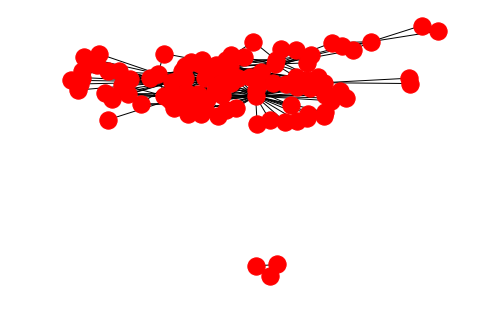

In [272]:
nx.draw_spring(G_authors,edge_color='k')

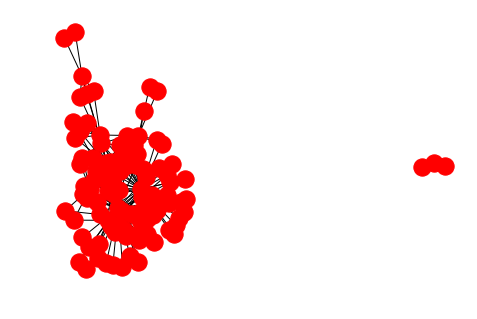

In [261]:
nx.draw_spring(G_authors)